In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Loading the data

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [4]:
df = pd.read_csv("C:/Users/angir/Downloads/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras-master/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras-master/data/creditcardfraud/creditcard.csv")

# Exploration

In [5]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [6]:
df.isnull().values.any()

np.False_

C:\Users\angir\AppData\Local\Temp\ipykernel_13668\2107955042.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


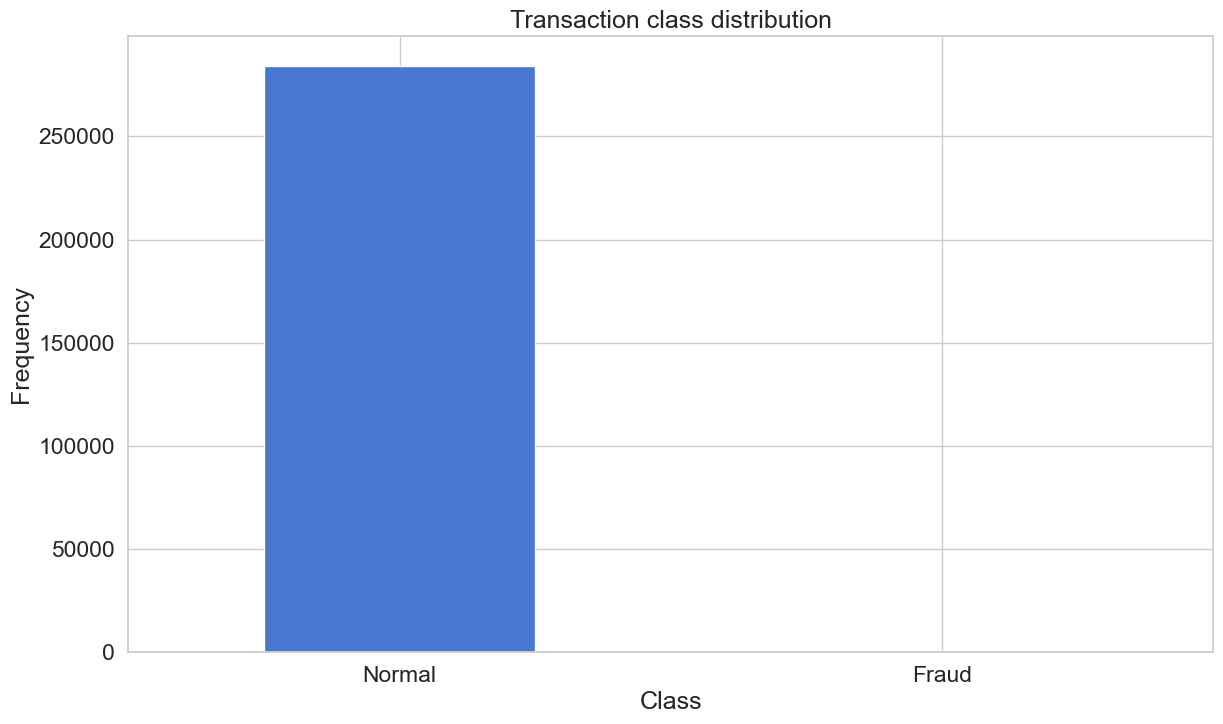

In [7]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions: 

In [8]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [9]:
frauds.shape

(492, 31)

In [10]:
normal.shape

(284315, 31)

In [11]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [12]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Let's have a more graphical representation:

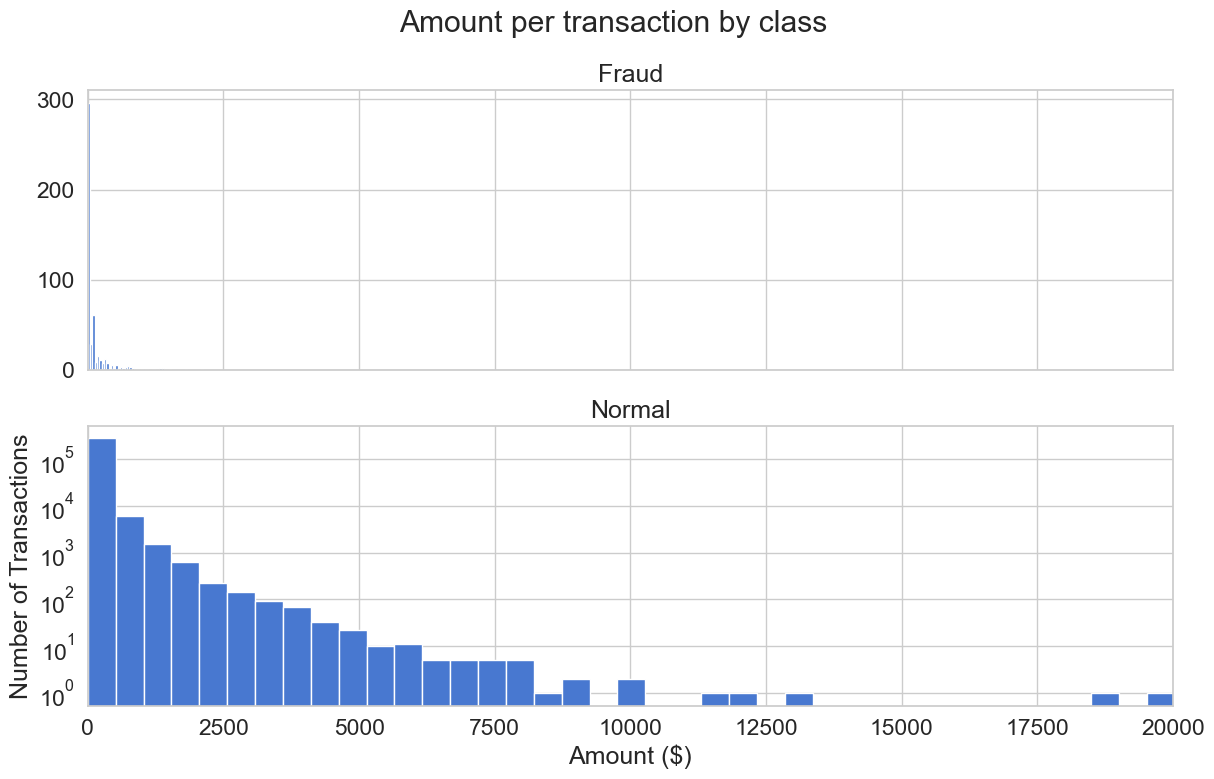

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Do fraudulent transactions occur more often during certain time?

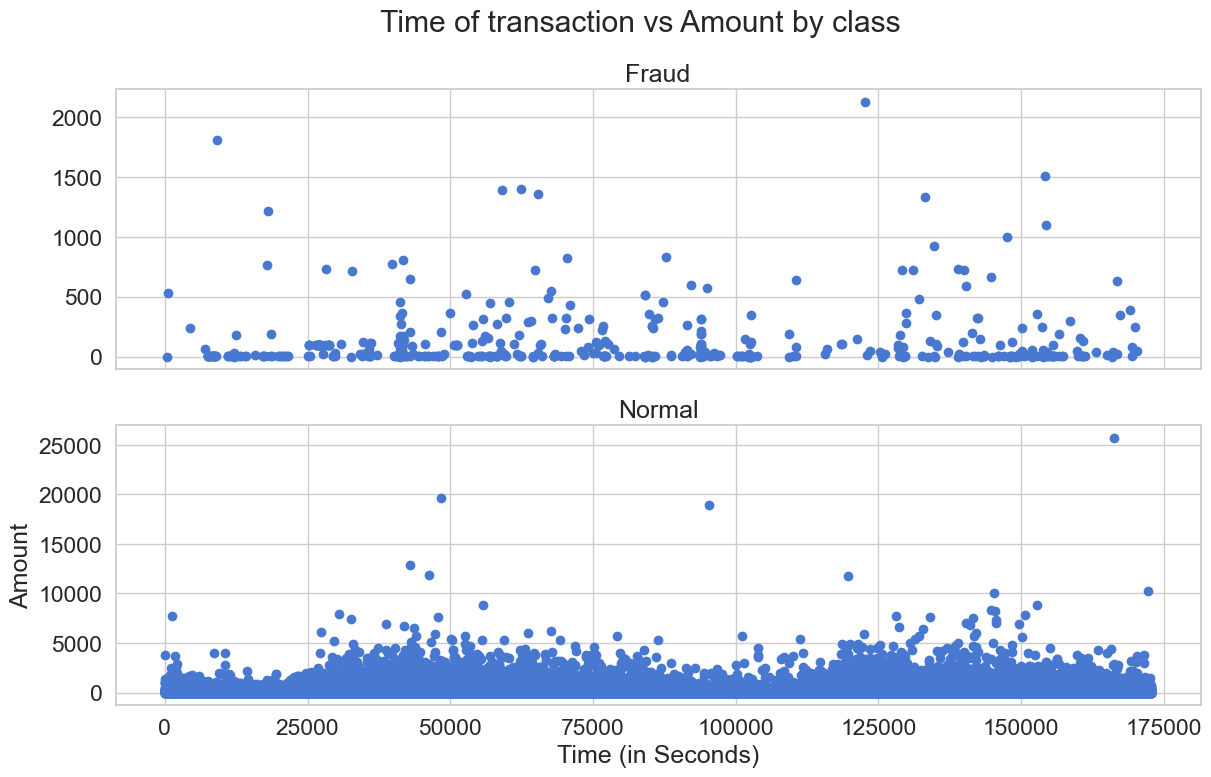

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [15]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [16]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [17]:
X_train.shape

(227451, 29)

# Building the model

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [18]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [19]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [20]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7106/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4959 - loss: 0.8814

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.4959 - loss: 0.8814 - val_accuracy: 0.6434 - val_loss: 0.7992
Epoch 2/100
7076/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6451 - loss: 0.7604

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6451 - loss: 0.7604 - val_accuracy: 0.6537 - val_loss: 0.7766
Epoch 3/100
7105/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6579 - loss: 0.7402

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6579 - loss: 0.7402 - val_accuracy: 0.6635 - val_loss: 0.7694
Epoch 4/100
7099/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6633 - loss: 0.7506

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6633 - loss: 0.7506 - val_accuracy: 0.6658 - val_loss: 0.7673
Epoch 5/100
7107/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6670 - loss: 0.7211

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6670 - loss: 0.7211 - val_accuracy: 0.6633 - val_loss: 0.7645
Epoch 6/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6635 - loss: 0.7172 - val_accuracy: 0.6693 - val_loss: 0.7650
Epoch 7/100
7096/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6648 - loss: 0.7180

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6648 - loss: 0.7180 - val_accuracy: 0.6695 - val_loss: 0.7636
Epoch 8/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6655 - loss: 0.7572 - val_accuracy: 0.6716 - val_loss: 0.7643
Epoch 9/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6670 - loss: 0.7214 - val_accuracy: 0.6634 - val_loss: 0.7650
Epoch 10/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6659 - loss: 0.7315 - val_accuracy: 0.6574 - val_loss: 0.7636
Epoch 11/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.6659 - loss: 0.7548 - val_accuracy: 0.6612 - val_loss: 0.7669
Epoch 12/100
7097/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6645 - loss: 0.7432

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.6645 - loss: 0.7432 - val_accuracy: 0.6661 - val_loss: 0.7604
Epoch 13/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6660 - loss: 0.7218 - val_accuracy: 0.6630 - val_loss: 0.7624
Epoch 14/100
7105/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6656 - loss: 0.7282

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6656 - loss: 0.7282 - val_accuracy: 0.6687 - val_loss: 0.7602
Epoch 15/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6683 - loss: 0.7183 - val_accuracy: 0.6713 - val_loss: 0.7606
Epoch 16/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6664 - loss: 0.7163 - val_accuracy: 0.6716 - val_loss: 0.7608
Epoch 17/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6672 - loss: 0.7315

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6672 - loss: 0.7315 - val_accuracy: 0.6736 - val_loss: 0.7600
Epoch 18/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6706 - loss: 0.7228 - val_accuracy: 0.6672 - val_loss: 0.7666
Epoch 19/100
7104/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6694 - loss: 0.7354

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.6694 - loss: 0.7354 - val_accuracy: 0.6699 - val_loss: 0.7592
Epoch 20/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6672 - loss: 0.7360 - val_accuracy: 0.6637 - val_loss: 0.7618
Epoch 21/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6668 - loss: 0.7362 - val_accuracy: 0.6718 - val_loss: 0.7657
Epoch 22/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6678 - loss: 0.7207 - val_accuracy: 0.6705 - val_loss: 0.7602
Epoch 23/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.6699 - loss: 0.7303 - val_accuracy: 0.6741 - val_loss: 0.7594
Epoch 24/100
7099/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6691 - loss: 0.7258

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.6691 - loss: 0.7258 - val_accuracy: 0.6740 - val_loss: 0.7590
Epoch 25/100
7102/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6692 - loss: 0.7332

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6692 - loss: 0.7332 - val_accuracy: 0.6754 - val_loss: 0.7584
Epoch 26/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6719 - loss: 0.7384 - val_accuracy: 0.6734 - val_loss: 0.7590
Epoch 27/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6714 - loss: 0.7240 - val_accuracy: 0.6736 - val_loss: 0.7595
Epoch 28/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6733 - loss: 0.7364 - val_accuracy: 0.6754 - val_loss: 0.7595
Epoch 29/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.6734 - loss: 0.7259 - val_accuracy: 0.6811 - val_loss: 0.7608
Epoch 30/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6751 - loss: 0.7144 - val_accuracy: 0.6761 - val_loss: 0.7606
Epoch 31/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6786 - loss: 0.7072 - val_accuracy: 0.6772 - val_loss: 0.7640
Epoch 32/100
7106/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6794 - loss:

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.6794 - loss: 0.7326 - val_accuracy: 0.6834 - val_loss: 0.7571
Epoch 33/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6824 - loss: 0.7115 - val_accuracy: 0.6875 - val_loss: 0.7585
Epoch 34/100
7095/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6833 - loss: 0.7286

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.6833 - loss: 0.7286 - val_accuracy: 0.6884 - val_loss: 0.7571
Epoch 35/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6856 - loss: 0.7599 - val_accuracy: 0.6838 - val_loss: 0.7585
Epoch 36/100
7095/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6881 - loss: 0.7075

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6881 - loss: 0.7075 - val_accuracy: 0.6835 - val_loss: 0.7566
Epoch 37/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6878 - loss: 0.7046 - val_accuracy: 0.6861 - val_loss: 0.7570
Epoch 38/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.6867 - loss: 0.7082 - val_accuracy: 0.6933 - val_loss: 0.7567
Epoch 39/100
7102/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6889 - loss: 0.7155

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6889 - loss: 0.7155 - val_accuracy: 0.6932 - val_loss: 0.7557
Epoch 40/100
7106/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6912 - loss: 0.7205

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.6912 - loss: 0.7205 - val_accuracy: 0.6997 - val_loss: 0.7553
Epoch 41/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6911 - loss: 0.7039 - val_accuracy: 0.6936 - val_loss: 0.7573
Epoch 42/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6920 - loss: 0.7163 - val_accuracy: 0.6871 - val_loss: 0.7565
Epoch 43/100
7104/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6928 - loss: 0.7067

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6928 - loss: 0.7067 - val_accuracy: 0.6969 - val_loss: 0.7552
Epoch 44/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6936 - loss: 0.7151 - val_accuracy: 0.6964 - val_loss: 0.7564
Epoch 45/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6921 - loss: 0.7112 - val_accuracy: 0.6990 - val_loss: 0.7571
Epoch 46/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6922 - loss: 0.7246 - val_accuracy: 0.6984 - val_loss: 0.7560
Epoch 47/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.6939 - loss: 0.7048 - val_accuracy: 0.6989 - val_loss: 0.7561
Epoch 48/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6942 - loss: 0.7175 - val_accuracy: 0.6966 - val_loss: 0.7560
Epoch 49/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6952 - loss: 0.7284 - val_accuracy: 0.6934 - val_loss: 0.7597
Epoch 50/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6932 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6963 - loss: 0.7157 - val_accuracy: 0.6973 - val_loss: 0.7547
Epoch 55/100
7104/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6963 - loss: 0.7068

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6963 - loss: 0.7068 - val_accuracy: 0.7006 - val_loss: 0.7542
Epoch 56/100
7106/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6955 - loss: 0.7123

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.6955 - loss: 0.7123 - val_accuracy: 0.7036 - val_loss: 0.7541
Epoch 57/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6950 - loss: 0.7199 - val_accuracy: 0.7064 - val_loss: 0.7555
Epoch 58/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.6979 - loss: 0.7265 - val_accuracy: 0.7030 - val_loss: 0.7576
Epoch 59/100
7107/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6989 - loss: 0.7210

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.6989 - loss: 0.7210 - val_accuracy: 0.7066 - val_loss: 0.7540
Epoch 60/100
7107/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6987 - loss: 0.7264

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.6987 - loss: 0.7264 - val_accuracy: 0.6971 - val_loss: 0.7536
Epoch 61/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6981 - loss: 0.7111 - val_accuracy: 0.7033 - val_loss: 0.7563
Epoch 62/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.6969 - loss: 0.7299 - val_accuracy: 0.7002 - val_loss: 0.7550
Epoch 63/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.6987 - loss: 0.7188 - val_accuracy: 0.7026 - val_loss: 0.7536
Epoch 64/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.6978 - loss: 0.7145 - val_accuracy: 0.6971 - val_loss: 0.7541
Epoch 65/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6999 - loss: 0.7322 - val_accuracy: 0.7020 - val_loss: 0.7541
Epoch 66/100
7106/7108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6996 - loss: 0.7166

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.6996 - loss: 0.7166 - val_accuracy: 0.7045 - val_loss: 0.7533
Epoch 67/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.6983 - loss: 0.7243 - val_accuracy: 0.7016 - val_loss: 0.7539
Epoch 68/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6991 - loss: 0.7152 - val_accuracy: 0.7053 - val_loss: 0.7542
Epoch 69/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.6984 - loss: 0.7151 - val_accuracy: 0.7028 - val_loss: 0.7547
Epoch 70/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.6979 - loss: 0.7229 - val_accuracy: 0.7041 - val_loss: 0.7562
Epoch 71/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.6997 - loss: 0.7084 - val_accuracy: 0.6970 - val_loss: 0.7550
Epoch 72/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.7017 - loss: 0.7057 - val_accuracy: 0.6946 - val_loss: 0.7559
Epoch 73/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.6980 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.6987 - loss: 0.7102 - val_accuracy: 0.7088 - val_loss: 0.7532
Epoch 75/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.7015 - loss: 0.7264 - val_accuracy: 0.6950 - val_loss: 0.7575
Epoch 76/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6962 - loss: 0.7287 - val_accuracy: 0.7008 - val_loss: 0.7562
Epoch 77/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6980 - loss: 0.7344 - val_accuracy: 0.7013 - val_loss: 0.7538
Epoch 78/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.7021 - loss: 0.7092 - val_accuracy: 0.7037 - val_loss: 0.7539
Epoch 79/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6998 - loss: 0.7028 - val_accuracy: 0.6992 - val_loss: 0.7554
Epoch 80/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6974 - loss: 0.7062 - val_accuracy: 0.7055 - val_loss: 0.7540
Epoch 81/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6985 - loss

7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7008 - loss: 0.7164 - val_accuracy: 0.7066 - val_loss: 0.7532
Epoch 84/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6995 - loss: 0.7224 - val_accuracy: 0.7001 - val_loss: 0.7559
Epoch 85/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6984 - loss: 0.7064 - val_accuracy: 0.6998 - val_loss: 0.7544
Epoch 86/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.6978 - loss: 0.7149 - val_accuracy: 0.7053 - val_loss: 0.7548
Epoch 87/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6984 - loss: 0.7099 - val_accuracy: 0.6991 - val_loss: 0.7542
Epoch 88/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6993 - loss: 0.7151 - val_accuracy: 0.7009 - val_loss: 0.7558
Epoch 89/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6997 - loss: 0.7138 - val_accuracy: 0.7053 - val_loss: 0.7541
Epoch 90/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6967 - loss

In [21]:
autoencoder = load_model('model.h5')

# Evaluation

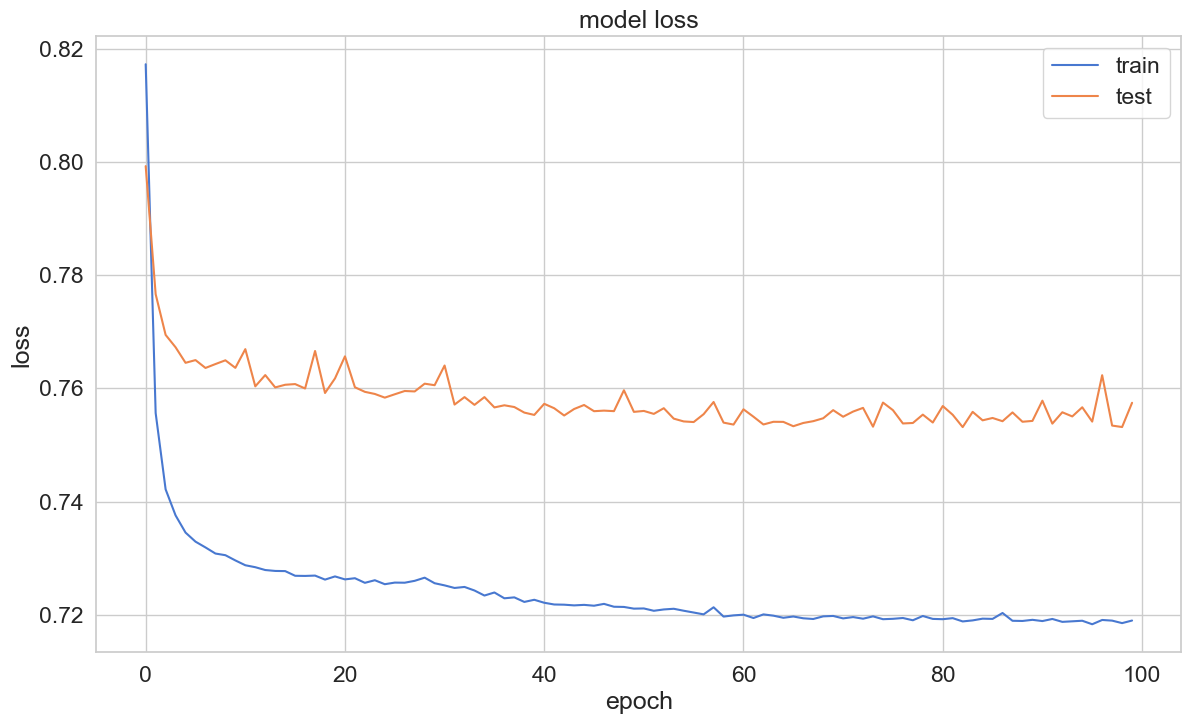

In [22]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [23]:
predictions = autoencoder.predict(X_test)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step


In [24]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [25]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.745315,0.001720
std,3.470551,0.041443
min,0.060451,0.000000
25%,0.260453,0.000000
50%,0.392438,0.000000
75%,0.610668,0.000000
max,267.513621,1.000000


## Reconstruction error without fraud

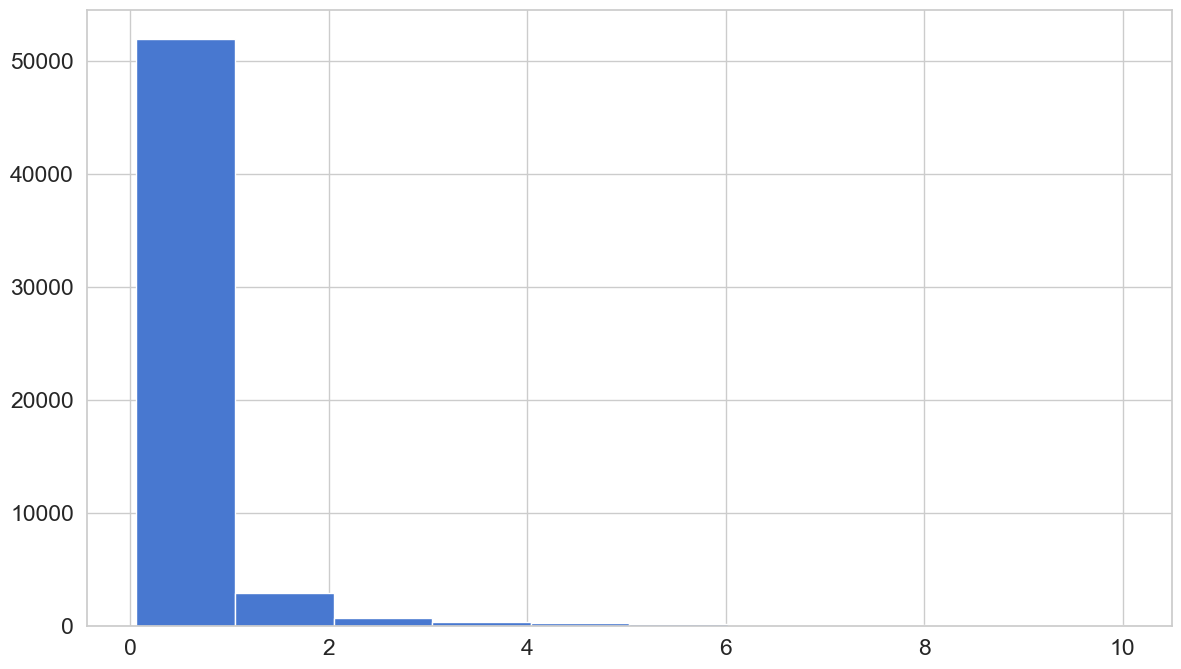

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Reconstruction error with fraud

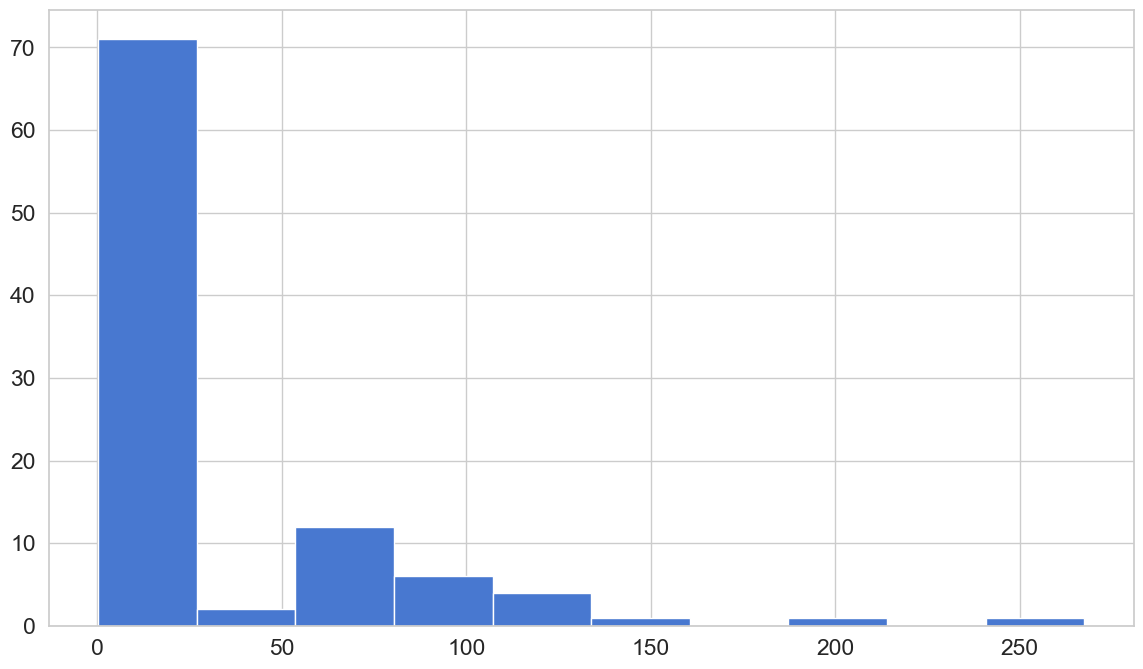

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [28]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

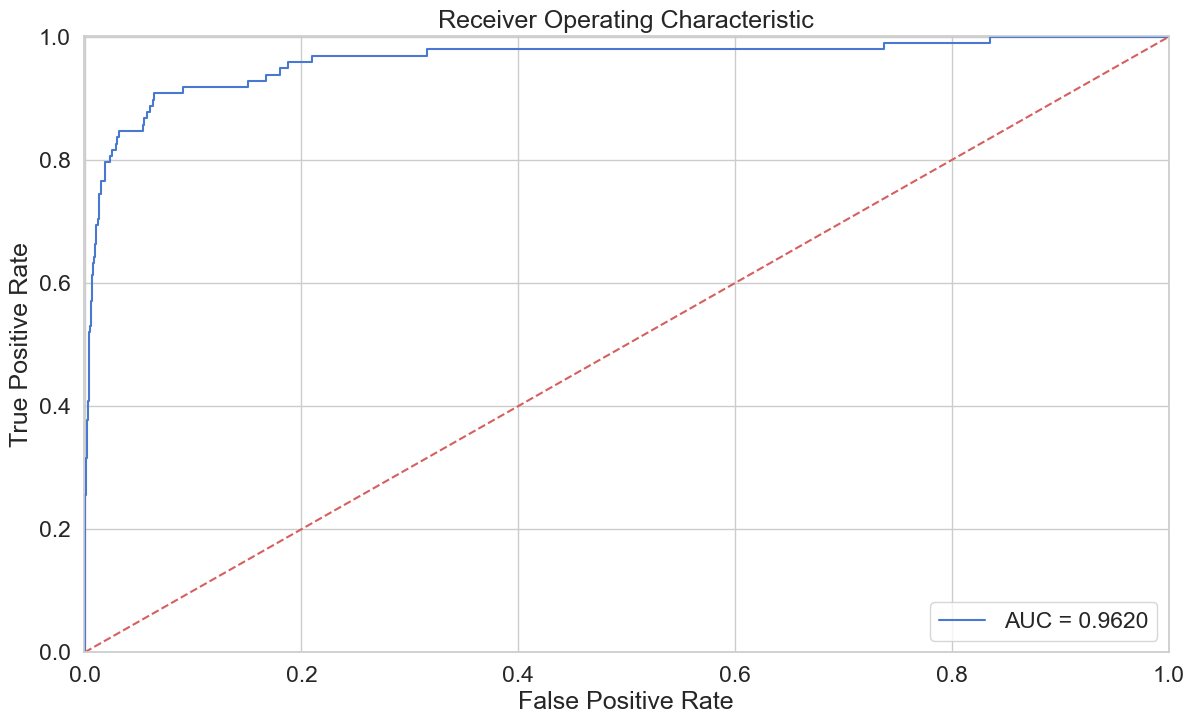

In [29]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

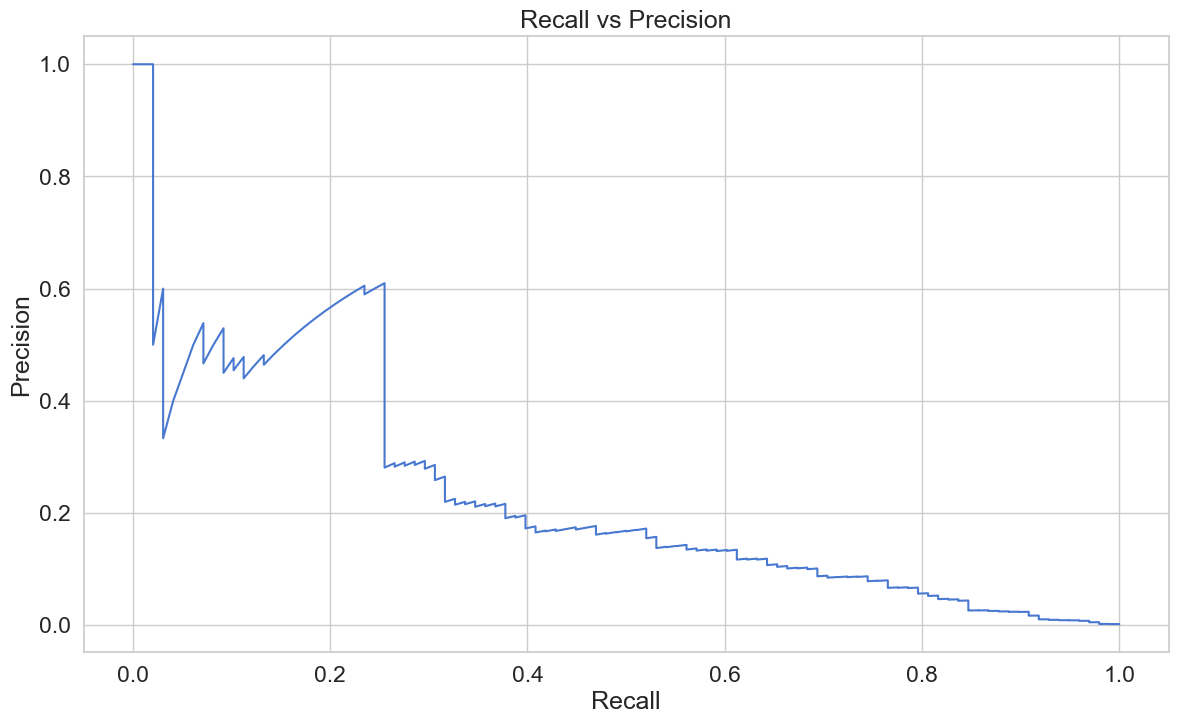

In [30]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

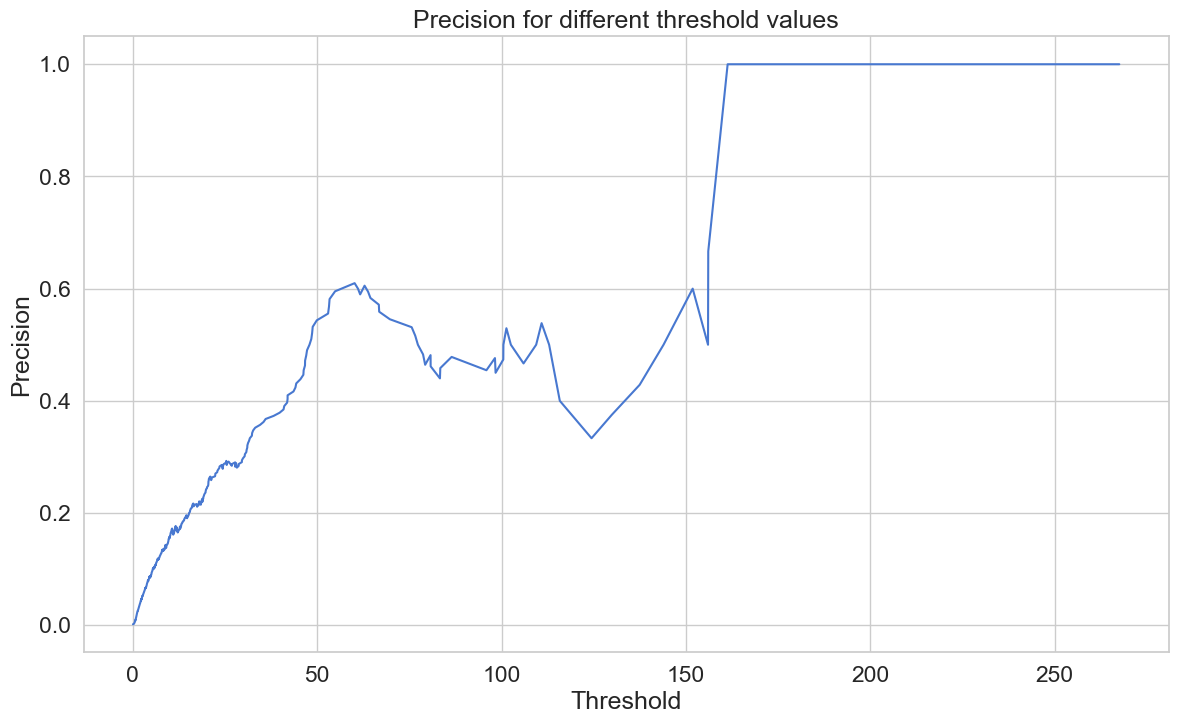

In [31]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

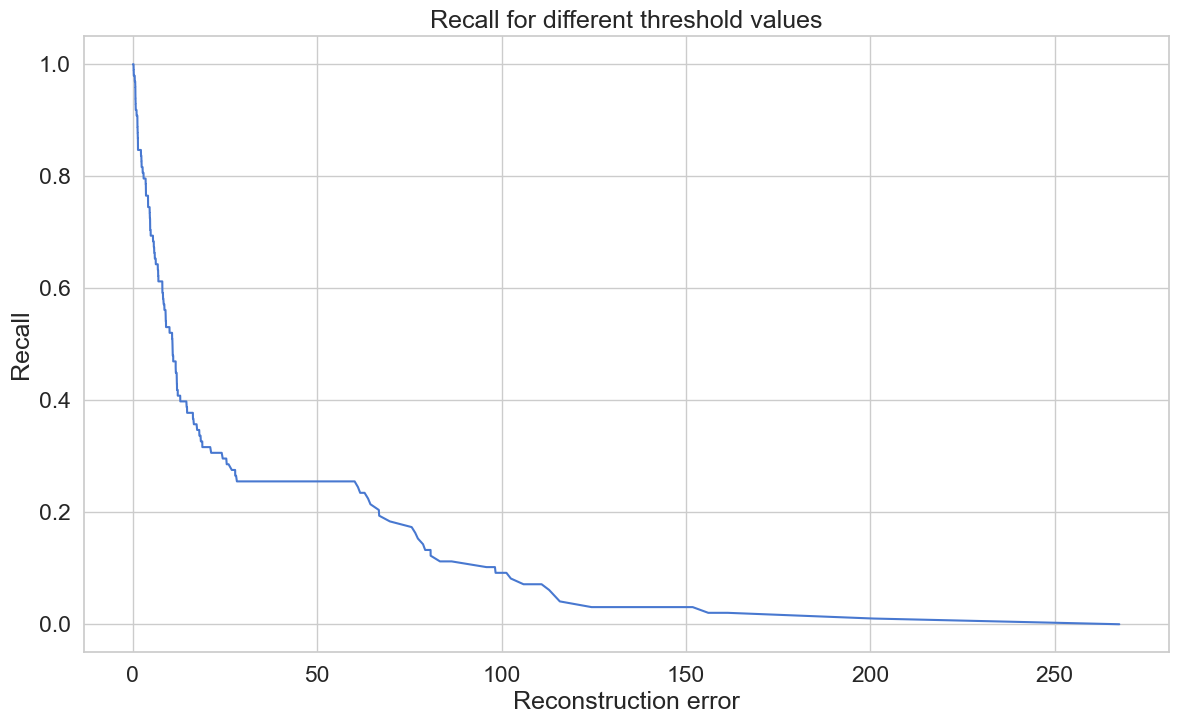

In [32]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

# Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [33]:
threshold = 2.9

And see how well we're dividing the two types of transactions:

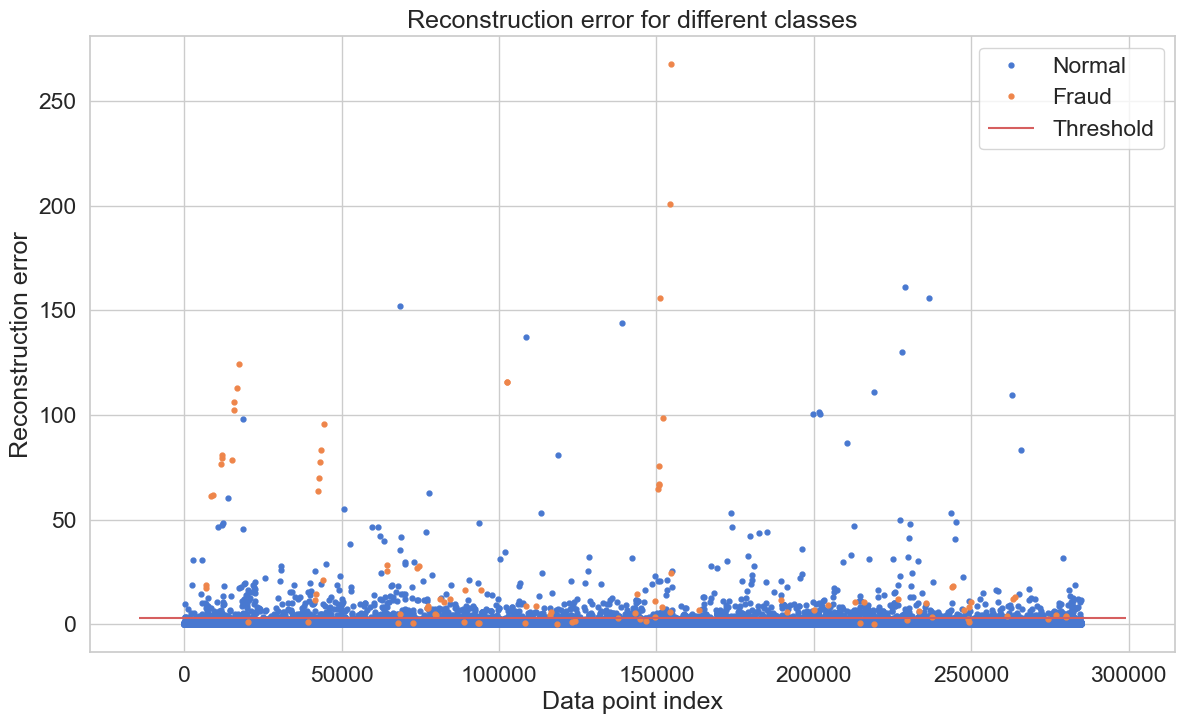

In [34]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

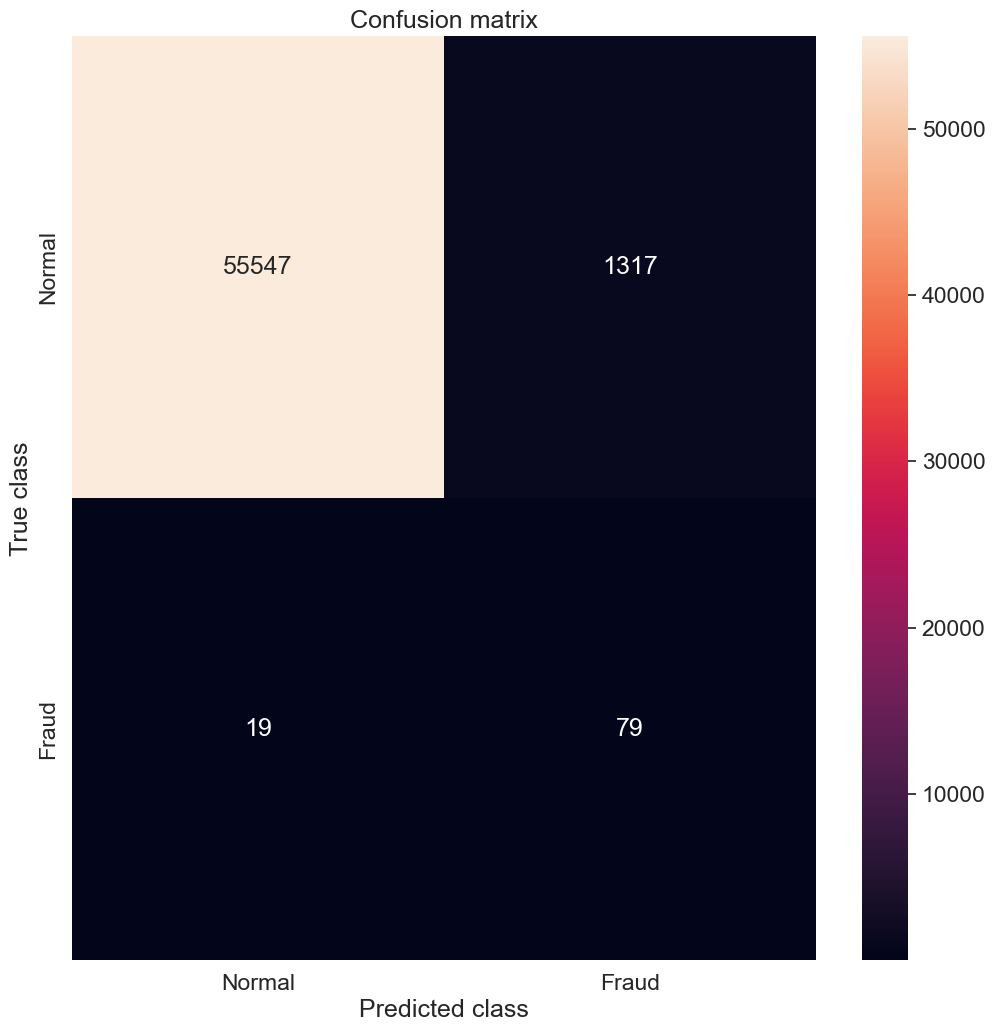

In [35]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()